In [3]:
import pandas as pd
import numpy as np
import seaborn as sns    
import xgboost as xgb
import shap
import matplotlib.pyplot as plt  
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

C:\Users\jasmi\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load el Data
train_df = pd.read_csv(r'C:/Users/jasmi/Downloads/kaggly competitions/ai-talents-league-round-1/train.csv')
test_df = pd.read_csv(r'C:/Users/jasmi/Downloads/kaggly competitions/ai-talents-league-round-1/test.csv')
sumity2 = pd.read_csv(r'C:/Users/jasmi/Downloads/kaggly competitions/ai-talents-league-round-1/sample_submission - Copy.csv')

In [5]:
# Remove el Duplicates
train_df.drop_duplicates(inplace=True)

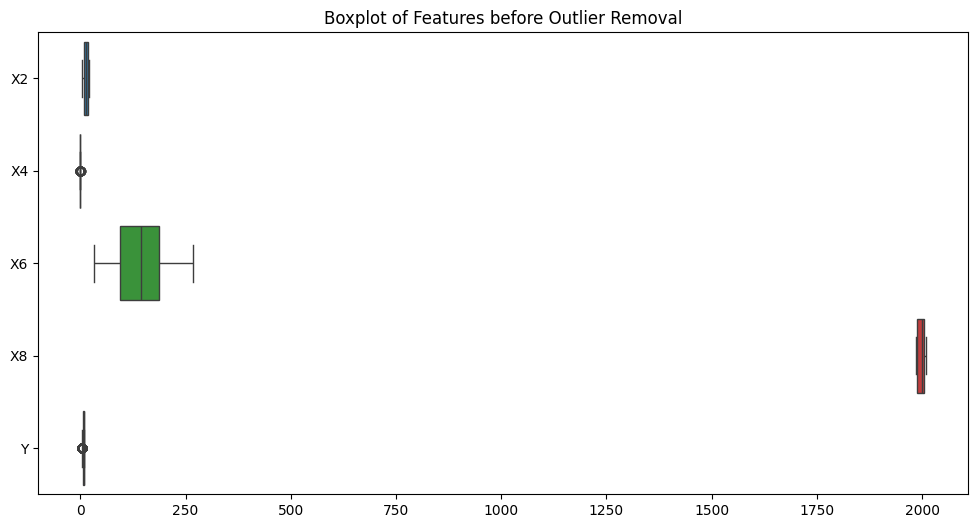

In [6]:
#Checking for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, orient='h')
plt.title('Boxplot of Features before Outlier Removal')
plt.show()

In [7]:
# Handle Outliers using IQR (Only for Numeric Columns)
numeric_cols = train_df.select_dtypes(include=['number']).columns
Q1 = train_df[numeric_cols].quantile(0.25)
Q3 = train_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
train_df = train_df[~((train_df[numeric_cols] < (Q1 - 1.5 * IQR)) | (train_df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [8]:
# Encode Categorical Columns
categorical_cols = ['X1', 'X3', 'X5', 'X7', 'X9', 'X10', 'X11']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols])

In [9]:
# Handle Missing Values with Median 
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('Y')
for col in num_cols:
    median_value = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

In [10]:
# Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(train_df.drop('Y', axis=1))
X_test_poly = poly.transform(test_df)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Target Variable
y_train = train_df['Y']

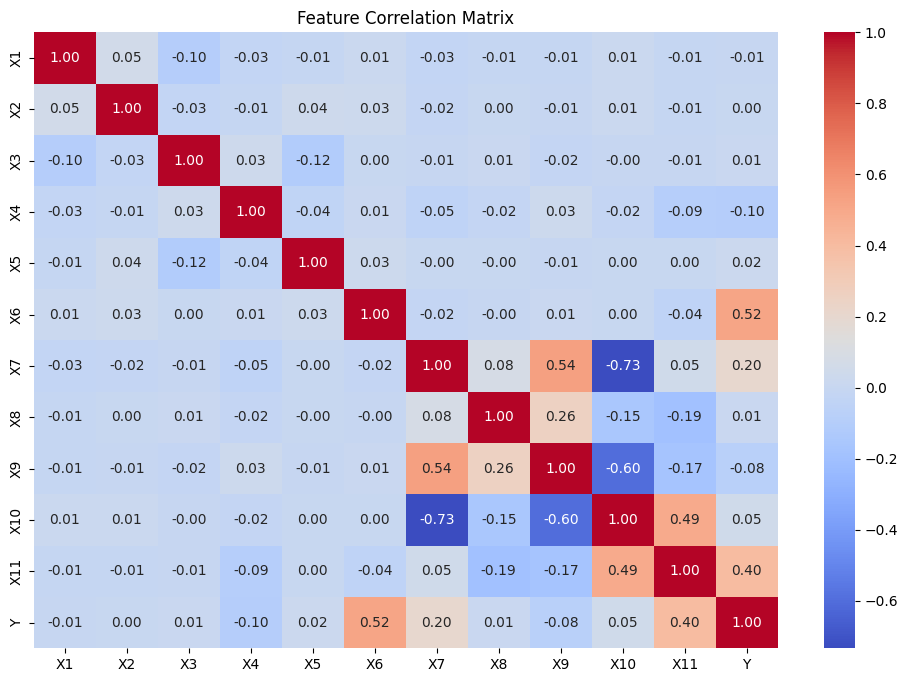

In [11]:
# Correlation Matrix Visualization
plt.figure(figsize=(12, 8))
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [12]:
# Feature Selection using SHAP Values (Optimized)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
explainer = shap.Explainer(rf)
shap_values = explainer(X_train_scaled, check_additivity=False)
feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(), 'SHAP_Importance': np.abs(shap_values.values).mean(axis=0)})
feature_importance = feature_importance.nlargest(30, 'SHAP_Importance')

# Select Top Features
selected_features = feature_importance['Feature'].values  
X_train_selected = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names_out())[selected_features]
X_test_selected = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names_out())[selected_features]


In [ ]:
# Define Models el regression
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [16]:
# Evaluate Models 3shan a decide a7sn model a2l mae
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    results[name] = mae
    print(f'{name} MAE: {mae}')

Linear Regression MAE: 0.412277367652825
Ridge Regression MAE: 0.4451175780374838
Lasso Regression MAE: 0.5226393028378997
Decision Tree MAE: 0.3894665174960059
Random Forest MAE: 0.1539774160027711
XGBoost MAE: 0.28281746670082447


In [17]:
# Identify el Best Model w hoa dah el 7ashta8l 3aleh
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f'\nBest Model: {best_model_name} with MAE: {results[best_model_name]}')


Best Model: Random Forest with MAE: 0.1539774160027711


In [18]:
# Feature Selection using SHAP Values
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
explainer = shap.Explainer(rf, X_train_scaled)
shap_values = explainer(X_train_scaled)
feature_importance = pd.DataFrame({'Feature': poly.get_feature_names_out(), 'SHAP_Importance': np.abs(shap_values.values).mean(axis=0)})
feature_importance = feature_importance.sort_values(by='SHAP_Importance', ascending=False)

100%|===================| 5773/5774 [24:58<00:00]        

In [19]:
# Select Top Features
top_features = feature_importance['Feature'].iloc[:30].values  
X_train_selected = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names_out())[top_features]
X_test_selected = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names_out())[top_features]

In [20]:
# Train Best Model (Random Forest) w e3mel Predictions
rf.fit(X_train_selected, y_train)
y_pred_test = rf.predict(X_test_selected)

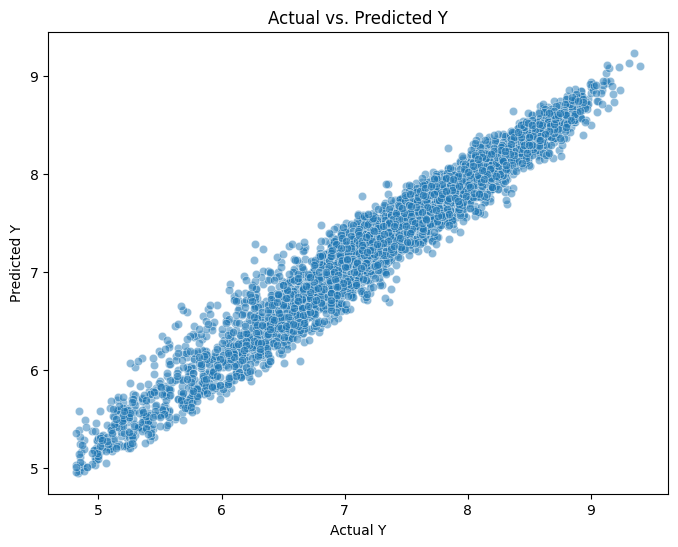

In [21]:
# Scatter Plot: Actual vs. Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=rf.predict(X_train_selected), alpha=0.5)
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Actual vs. Predicted Y")
plt.show()

In [22]:
# Save Submission File
sumity2['Y'] = y_pred_test[:len(sumity2)]  
sumity2.to_csv('submission_optimized.csv', index=False)